In [1]:
# Common libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Linear regression Question libraries
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

# Logistic Regression Question Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/atorell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/atorell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/atorell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
file_path = '/scratch/eecs448w24_class_root/eecs448w24_class/shared_data/valr/Combined_Goodreads_Data.csv'
df = pd.read_csv(file_path)
print(df.head(10))
print(df["date_added"])
print(df["publication_date"])

   Unnamed: 0  book_id                                              title  \
0           1        1  Harry Potter and the Half-Blood Prince (Harry ...   
1           2        1  Harry Potter and the Half-Blood Prince (Harry ...   
2           3        1  Harry Potter and the Half-Blood Prince (Harry ...   
3           4        1  Harry Potter and the Half-Blood Prince (Harry ...   
4           5        1  Harry Potter and the Half-Blood Prince (Harry ...   
5           6        1  Harry Potter and the Half-Blood Prince (Harry ...   
6           7        1  Harry Potter and the Half-Blood Prince (Harry ...   
7           8        1  Harry Potter and the Half-Blood Prince (Harry ...   
8           9        1  Harry Potter and the Half-Blood Prince (Harry ...   
9          10        1  Harry Potter and the Half-Blood Prince (Harry ...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   


In [3]:
# converting date_added into the same format of publication date
from datetime import datetime
import pandas as pd

df = pd.DataFrame(df)

# Convert date_added column to datetime objects
try:
    df['date_added'] = pd.to_datetime(df['date_added'], utc=True)
except ValueError as e:
    print("Error converting date_added column:", e)

# Format datetime objects as desired
if 'date_added' in df.columns:
    df['formatted_date_added'] = df['date_added'].dt.strftime("%m/%d/%Y")

print(df['formatted_date_added'])

0        02/23/2014
1        05/25/2016
2        06/08/2010
3        08/23/2015
4        10/24/2009
            ...    
54946    04/28/2013
54947    10/18/2009
54948    07/10/2016
54949    04/23/2014
54950    07/19/2009
Name: formatted_date_added, Length: 54951, dtype: object


In [4]:
df['formatted_date_added'] = pd.to_datetime(df['formatted_date_added'], utc=True)
df['publication_date'] = pd.to_datetime(df['publication_date'])

df['formatted_date_added'] = pd.to_datetime(df['formatted_date_added']).dt.tz_localize(None)

# Calculate the time difference between publication_date and date_added
df['time_difference_days'] = (df['formatted_date_added'] - df['publication_date']).dt.days

print(df['time_difference_days'])

0        2717
1        3539
2        1361
3        3263
4        1134
         ... 
54946    3223
54947    1935
54948    4392
54949    3583
54950    1844
Name: time_difference_days, Length: 54951, dtype: int64


In [5]:
df['review_word_count'] = df['review_text'].str.split().str.len()

print(df['review_word_count'])

0         26
1         31
2        141
3         15
4         73
        ... 
54946    104
54947    141
54948    408
54949     24
54950     28
Name: review_word_count, Length: 54951, dtype: int64


In [6]:
print(df['text_reviews_count'])

0        27591
1        27591
2        27591
3        27591
4        27591
         ...  
54946      589
54947      589
54948      589
54949      589
54950      589
Name: text_reviews_count, Length: 54951, dtype: int64


In [7]:
df['num_reviews'] = df.groupby('user_id')['user_id'].transform('size')

In [8]:
print(df['num_reviews'])

0        11
1         4
2        16
3         2
4        20
         ..
54946    17
54947    27
54948    12
54949    28
54950    61
Name: num_reviews, Length: 54951, dtype: int64


In [9]:
nltk_stopwords = set(stopwords.words('english'))

def PreprocessSentence(sentence, nltk_stopwords):
    # Input - a sentence in the form of a python string, and the set of stopwords
    # Output - the preprocessed sentence, as per the instructions
    
    sentence = sentence.lower()
    tokens = word_tokenize(sentence)
    #remove stopwords and single char non-num words
    tokens = [word for word in tokens if word not in nltk_stopwords and (word.isnumeric() or len(word) > 1)]
    preprocessed_sentence = ' '.join(tokens)
    return preprocessed_sentence

def PreprocessData(df, nltk_stopwords):
    # Input - the dataframe, with columns label and text, and the set of stopwords
    # output - the dataframe with the text processed as described earlier
    df['review_text'] = df['review_text'].map(lambda x: PreprocessSentence(x, nltk_stopwords))
    return df
df = PreprocessData(df, nltk_stopwords)

In [10]:
# %pip install nltk
# %pip install vaderSentiment
# %pip install langdetect
# %pip install spacy

In [11]:
df['num_book'] = df.groupby('book_id')['book_id'].transform('size')
print(df['num_book'])

0        390
1        390
2        390
3        390
4        390
        ... 
54946     18
54947     18
54948     18
54949     18
54950     18
Name: num_book, Length: 54951, dtype: int64


In [23]:
# Filter out instances where n_votes is 0
df = df[df['n_votes'] != 0]

# Define bins for n_votes with increments of 10 up to 100
df['n_votes_bin'] = pd.qcut(df['n_votes'], q=6, labels=False, duplicates='drop')
print("Number of NaN values in 'n_votes' column:", df['n_votes_bin'].isna().sum())
# Check the number of rows in the 'n_votes_bin' column
print("Number of rows in 'n_votes_bin' column:", df['n_votes_bin'].shape[0])
print(df['n_votes_bin'].value_counts())

Number of NaN values in 'n_votes' column: 0
Number of rows in 'n_votes_bin' column: 17578
0    7504
1    2906
3    2891
4    2742
2    1535
Name: n_votes_bin, dtype: int64


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Sample DataFrame
df = pd.DataFrame(df)

# Calculate tf-idf values for review_text
# tfidf_vectorizer = TfidfVectorizer()
# X_tfidf = tfidf_vectorizer.fit_transform(df['review_text'])
analyzer = SentimentIntensityAnalyzer()
df["review_sentiment"] = df["review_text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

# Create feature vector
feature_vector = df[['time_difference_days', 'review_word_count', 'num_reviews', 'rating', 'review_sentiment', "num_book"]]
# feature_vector = df[['review_sentiment', 'num_reviews']]
# Convert tf-idf matrix to DataFrame and concatenate with feature_vector
# X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
#X_combined = hstack([feature_vector, X_tfidf])
#feature_vector = pd.concat([feature_vector, X_tfidf_df], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, df['n_votes_bin'], test_size=0.2, random_state=42)
#print(X_combined.todense()[:5])
#print(X_train.head())

In [29]:
from sklearn.naive_bayes import GaussianNB
# Initialize and train the multinomial logistic regression model
model = LogisticRegression(max_iter=1000, solver="sag")
#model = GaussianNB()
model.fit(X_train, y_train)

# Predict ratings for the training set
y_train_pred = model.predict(X_train)

# Predict ratings for the test set
y_test_pred = model.predict(X_test)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.43685108803868583
Testing Accuracy: 0.42974971558589303


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# test = np.array(y_test_pred == (y_test))
# print(test)
comparison = np.abs(y_test_pred - y_test)
print(comparison)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared (R²) score
r2 = r2_score(y_test, y_test_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R²) score:", r2)

11728    1.439866
3951     2.222012
53352    1.646030
1253     0.925156
54016    2.335350
           ...   
31833    2.696519
14806    0.005827
15048    1.022786
37809    1.144564
4684     0.701133
Name: n_votes_bin, Length: 3516, dtype: float64
Mean Squared Error (MSE): 2.2176790906665147
R-squared (R²) score: 0.08427513953337473


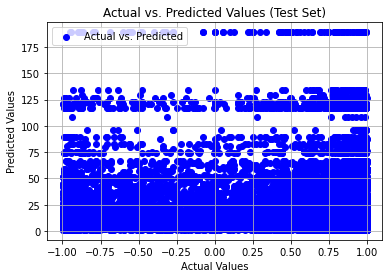

In [27]:
import matplotlib.pyplot as plt
# Plotting the actual values against the predicted values for the test set
plt.scatter(df['review_sentiment'], df['num_reviews'], color='blue', label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

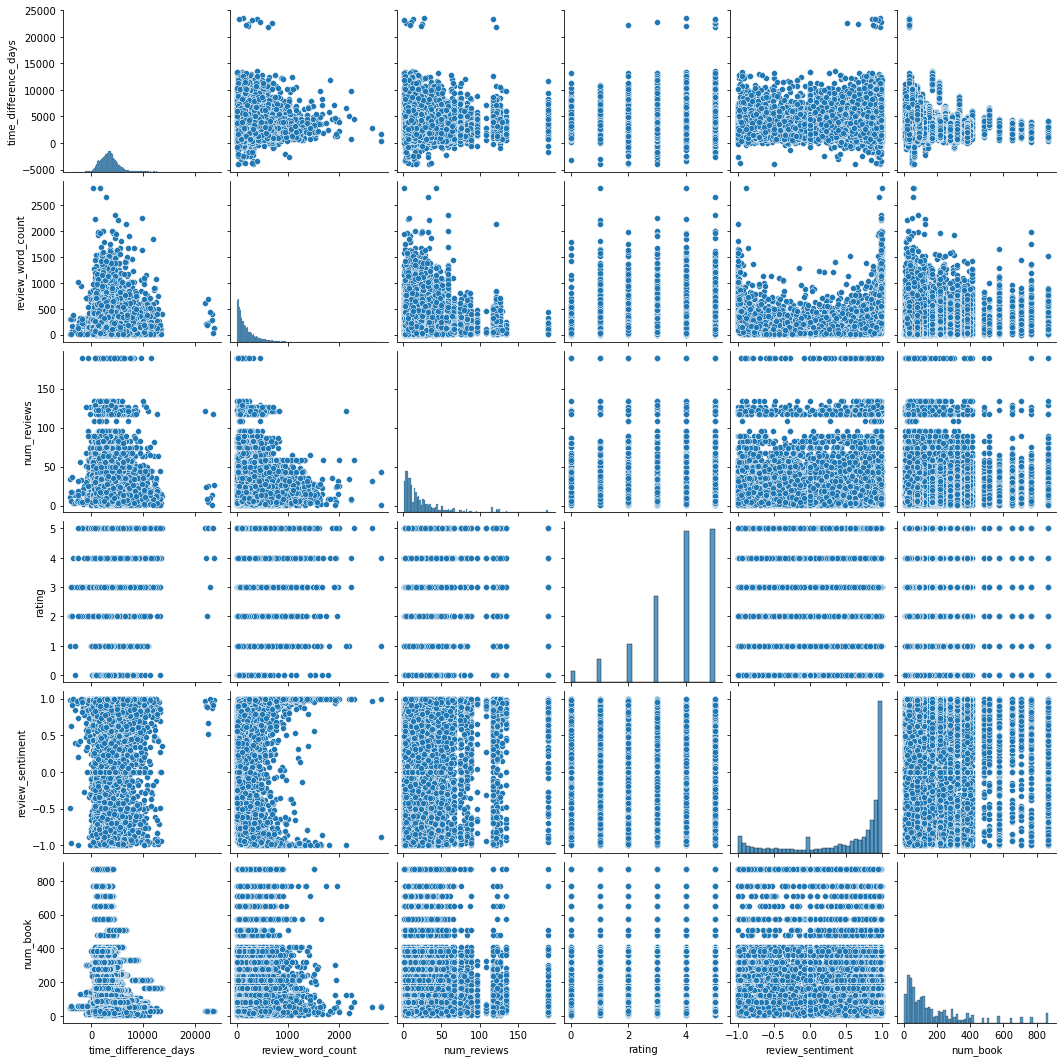

In [17]:
import seaborn as sns
sns.pairplot(feature_vector)
plt.show()

In [28]:
import numpy as np

def recall_from_covariance(covariance_matrix):
    """
    Compute recall given the covariance matrix (confusion matrix).
    """
    true_positives = np.diag(covariance_matrix)
    false_negatives = np.sum(covariance_matrix, axis=1) - true_positives
    recalls = true_positives / (true_positives + false_negatives)
    return recalls

def unweighted_average_recall_from_covariance(covariance_matrix):
    """
    Compute the unweighted average recall given the covariance matrix (confusion matrix).
    """
    recalls = recall_from_covariance(covariance_matrix)
    return np.mean(recalls)

covariance_matrix = np.cov(feature_vector, rowvar=False)
covariance_matrix = np.array(covariance_matrix)

average_recall = unweighted_average_recall_from_covariance(covariance_matrix)
print("Unweighted Average Recall:", average_recall)

Unweighted Average Recall: -0.008214548870560797
